In [1]:
using Distributions
using LinearAlgebra
using Plots
using Random

In [2]:
function true_likelihood(theta)
    return exp(-abs(theta))
end


function true_prior(theta)
    # uniform on [-40, 60]
    if -40 <= theta <= 60
        return (1/100)
    else
        return 0
    end
end
function true_posterior(theta)
    # ignoring prior
    return exp(-abs(theta))/2
end

function ess_pdf(theta)
    # ignoring prior
    return exp(-abs(theta)/2)/4
end


function targeted_pdf(theta)
    # ignoring prior
    pdf.(Chisq(4), abs(theta))/2 
end

function sumzero(list, returntype = Float64)
    if length(list) == 0
        return zero(Float64)
    else
        return sum(list)
    end
end

function simulate(thetas; likelihood = true_likelihood)
    # one simulation for each theta
    if ~(minimum(likelihood.(thetas)) >= 0)
        print(thetas)
        print(likelihood)
        
        @assert minimum(likelihood.(thetas)) >= 0
    end
    @assert maximum(likelihood.(thetas)) <= 1
    return rand.(Binomial.(1, likelihood.(thetas)))
end

function rejection_estimate(simulated_params, sim_results; importance_pdf = true_prior, f = x -> x, prior = true_prior)
    weights = sim_results .* (prior.(simulated_params)) ./ importance_pdf.(simulated_params)
    return dot(f.(simulated_params), weights) / sum(weights)
end

function ess(simulated_params, sim_results; prior = true_prior, importance_pdf = true_prior)
    weights = sim_results .* (prior.(simulated_params)) ./ importance_pdf.(simulated_params)
    return sum(weights)^2/sum(weights.^2)
end

function categorical_mean(points, weights)
    if (length(points) == 0 )| (sum(weights) == 0)
        return 0
    else
        if length(size(points)) == 1
            points = points'
        end
        relative_weights = weights/sum(weights)
        return points*relative_weights
    end
end

function categorical_second_moment(points, weights)
    
    if (length(points) == 0) | (sum(weights) == 0)
        return 0
    else
        if length(size(points)) == 1
            points = points'
        end
        relative_weights = weights/sum(weights)
        points_squared = [points[:,i]*points[:,i]' for i in 1:size(points, 2)]
        moment = sum([points_squared[i]*relative_weights[i] for i in 1:size(points, 2)])
        if length(moment) == 1
            return moment[1]
        else
            return moment
        end
    end
end

function categorical_covariance(points, weights)
    if (length(points) == 0) | (sum(weights) == 0)
        return 1
    end
    m = categorical_mean(points, weights)
    s = categorical_second_moment(points, weights)
    if s < m*m'
        print(points[weights .> 0], weights[weights .> 0])
    end
    return s - m*m'
end

categorical_covariance (generic function with 1 method)

In [3]:
function simulate_experiment(total_N, sampler::Function, prior, true_likelihood; target_function = x -> x, batch_size = 1)

    thetas = []
    sim_results = []
    importance_pdfs = []
    for batch in 1:Int64(total_N/batch_size)
        # All approaches in this notebook (for the simple continuous example in Fig. 3) have batch_size = total_N
        # This loop structure allows sampling to be adaptive
        next_thetas, next_importance_pdf = sampler(thetas = thetas[1:((batch-1)*batch_size)],
            sim_results = sim_results[1:((batch-1)*batch_size)],
            prior = prior,
            true_likelihood = true_likelihood,
            num_samples = batch_size)
        append!(importance_pdfs, [next_importance_pdf])
        append!(thetas, next_thetas)
        append!(sim_results, simulate(next_thetas, likelihood = true_likelihood))
    end
    return thetas, sim_results, x -> sum([q(x) for q in importance_pdfs])/length(importance_pdfs)
end

function prior_sampler(;thetas = nothing, sim_results = nothing, prior = true_prior, true_likelihood = nothing, num_samples = 1)
    return rand(Uniform(-40,60), num_samples), prior
end

function posterior_sampler(;thetas = nothing, sim_results = nothing, prior = true_prior, true_likelihood = nothing, num_samples = 1)
    # ignoring prior
    signs = (-1).^(rand(num_samples).>0.5)
    magnitudes = rand(Exponential(1), num_samples)
    return signs .* magnitudes, true_posterior
end

function targeted_sampler(;thetas = nothing, sim_results = nothing, prior = true_prior, true_likelihood = true_likelihood, num_samples = 1)
    signs = (-1).^(rand(num_samples).>0.5)
    magnitudes = rand(Chisq(4), num_samples)
    return signs .* magnitudes, targeted_pdf
end

function ess_sampler(;thetas = nothing, sim_results = nothing, prior = true_prior, true_likelihood = nothing, num_samples = 1)
    signs = (-1).^(rand(num_samples).>0.5)
    magnitudes = rand(Exponential(2), num_samples)
    return signs .* magnitudes, ess_pdf
end

    

ess_sampler (generic function with 1 method)

In [4]:
function experiment_squared_error(total_N::Int64, sampler::Function, prior, true_likelihood; num_trials = 1000, batch_size = 1)
    
    
    errors = zeros(num_trials)
    effective_sample_sizes = zeros(num_trials)
    
    target_function = x -> x
    posterior_mean = 0
    importance_pdf = nothing
    for i in 1:num_trials
        params, sim_results, importance_pdf = simulate_experiment(total_N, sampler, prior, true_likelihood; batch_size = batch_size)
        estimated_mean = rejection_estimate(params, sim_results, importance_pdf = importance_pdf, f = target_function, prior = prior)        
        errors[i] = (posterior_mean - estimated_mean)^2
        effective_sample_sizes[i] = ess(params, sim_results, importance_pdf = importance_pdf, prior = prior)
    end
    if num_trials == 1
        return errors[1], importance_pdf
    else
        return (errors, importance_pdf, effective_sample_sizes)
    end
end

function experiment_squared_error(total_Ns::Vector, sampler::Function, prior, true_likelihood; num_trials = 1000, num_rounds = 1)
    errors_and_pdfs = [experiment_squared_error(n, sampler, prior, true_likelihood, num_trials = num_trials, batch_size = Int64(n/num_rounds)) for n in total_Ns]
    
    errors = [out[1] for out in errors_and_pdfs]
    pdfs = [out[2] for out in errors_and_pdfs]
    effective_sample_sizes = [out[3] for out in errors_and_pdfs]
    
    return errors, pdfs, effective_sample_sizes
end

experiment_squared_error (generic function with 2 methods)

In [5]:

prior_dict = Dict("sampler" => prior_sampler,
    "label" => "prior",
    "num_rounds" => 1,
    "plot_offset" => 2^(-0.15),
)
posterior_dict = Dict("sampler" => posterior_sampler,
    "label" => "posterior",
    "num_rounds" => 1,
    "plot_offset" => 2^(-0.05),
)
ess_dict = Dict("sampler" => ess_sampler,
    "label" => "maximum ESS",
    "num_rounds" => 1,
    "plot_offset" => 2^(0.05),
)
targeted_dict = Dict("sampler" => targeted_sampler,
    "label" => "targeting mean",
    "num_rounds" => 1,
    "plot_offset" => 2^(0.15),
)
all_result_dicts = [prior_dict,
    posterior_dict,
    ess_dict,
    targeted_dict]

4-element Array{Dict{String,Any},1}:
 Dict("label" => "prior","num_rounds" => 1,"plot_offset" => 0.9012504626108302,"sampler" => prior_sampler)           
 Dict("label" => "posterior","num_rounds" => 1,"plot_offset" => 0.9659363289248456,"sampler" => posterior_sampler)   
 Dict("label" => "maximum ESS","num_rounds" => 1,"plot_offset" => 1.0352649238413776,"sampler" => ess_sampler)       
 Dict("label" => "targeting mean","num_rounds" => 1,"plot_offset" => 1.109569472067845,"sampler" => targeted_sampler)

In [6]:
total_ns = 2 .^(7:15)
num_trials = 1000
Random.seed!(300)

function test_squared_error(sampler::Function, num_rounds::Int64; num_trials = num_trials)
    
    return experiment_squared_error(total_ns, sampler, true_prior, true_likelihood, num_trials = num_trials, num_rounds = num_rounds)
end

for dict in all_result_dicts
    println(dict["label"])
    @time dict["errors"], dict["single_importance_pdfs"], dict["effective_sample_sizes"] = test_squared_error(dict["sampler"], dict["num_rounds"])
end

prior
 84.518916 seconds (1.30 G allocations: 36.186 GiB, 4.49% gc time)
posterior
 85.537848 seconds (1.30 G allocations: 37.433 GiB, 4.49% gc time)
maximum ESS
 87.391553 seconds (1.30 G allocations: 37.410 GiB, 4.63% gc time)
targeting mean
 94.161519 seconds (1.30 G allocations: 37.429 GiB, 4.39% gc time)


20.010000000000005
99.99631600109987
99.32809671634939
95.96544028627


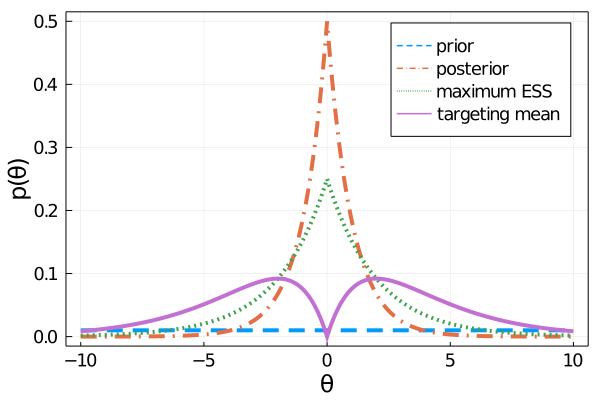

In [7]:
legendfontsize = 12
tickfontsize = 12
labelfontsize = 16

styles = [:dash, :dashdot, :dot, :solid]
p = plot()
for (dict, style) in zip(all_result_dicts, styles)
    thetas = -10:0.01:10
    println(sum(dict["single_importance_pdfs"][end].(thetas)))
    plot!(thetas, dict["single_importance_pdfs"][end].(thetas),
        label = dict["label"],
        linewidth = 4,
        framestyle = :box,
        linestyle = style,
        ylabel = "p(θ)",
        xlabel = "θ",
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
    )
end

plot(p)

In [8]:
for dict in all_result_dicts
    for prefix in ["error", "effective_sample_size"]
        dict[prefix*"_means"] = mean.(dict[prefix*"s"])
        dict[prefix*"_vars"] = var.(dict[prefix*"s"])
    end
end

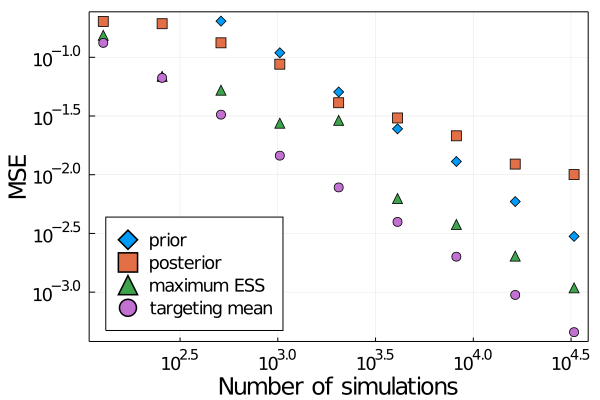

In [9]:
gr()
marker_size = 5
markers = [(m, marker_size) for m in [:diamond, :square, :utriangle, :circle]]
p = scatter()
for (dict, marker) in zip(all_result_dicts, markers)
    scatter!(reverse(total_ns), reverse(dict["error_means"]),
        xscale = :log10,
        yscale = :log10,
        label = dict["label"],
        framestyle = :box,
        m = marker,
        ylabel = "MSE",
        xlabel = "Number of simulations",
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
        legend = :bottomleft)
end

plot(p)

prior: 0.02002273123604911
posterior: 0.21990868147644027
maximum ESS: 0.25984582185025806
targeting mean: 0.06239696733700119


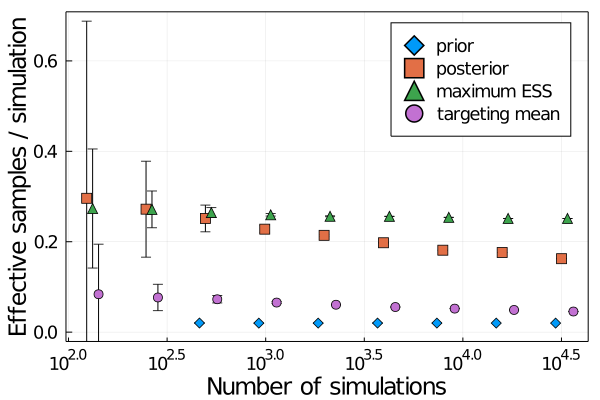

In [10]:
gr()
p = scatter()
for (dict, marker) in zip(all_result_dicts, markers)
    println(dict["label"], ": ", mean(dict["effective_sample_size_means"][.~ isnan.(dict["effective_sample_size_means"])]./total_ns[.~ isnan.(dict["effective_sample_size_means"])]))
    scatter!(reverse(total_ns).*dict["plot_offset"], reverse(dict["effective_sample_size_means"])./reverse(total_ns),
        xscale = :log10,
        yerr = sqrt.(dict["effective_sample_size_vars"])./sqrt(num_trials)./reverse(total_ns),
        label = dict["label"],
        framestyle = :box,
        m = marker,
        ylabel = "Effective samples / simulation",
        xlabel = "Number of simulations",
        ylim = [0, :auto],
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
        legend = :topright)
end

plot(p)

prior: NaN
posterior: 8.127890058057472
maximum ESS: 1.9346329198009995
targeting mean: 1.0


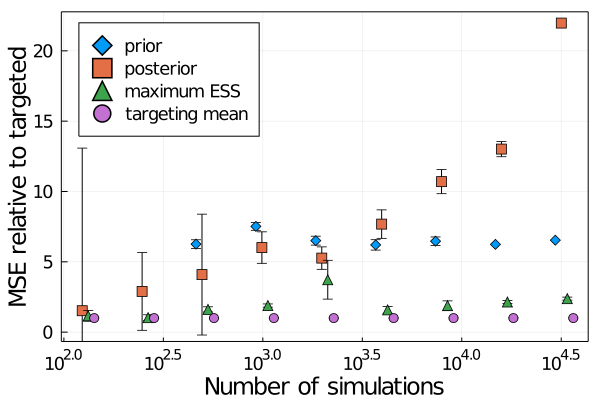

In [11]:
p = scatter()
for (dict, marker) in zip(all_result_dicts, markers)
    println(dict["label"], ": ", mean(dict["error_means"]./targeted_dict["error_means"]))
    scatter!(reverse(total_ns).*dict["plot_offset"], reverse(dict["error_means"]./targeted_dict["error_means"]),
        xscale = :log10,
        ylim = [0, :auto],
        yerr = sqrt.(dict["error_vars"]./num_trials)./targeted_dict["error_means"],
        label = dict["label"],
        framestyle = :box,
        m = marker,
        ylabel = "MSE relative to targeted",
        xlabel = "Number of simulations",
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
        legend = :topleft)
end
plot(p)